In [ ]:
# for reading writing and visulaizing the image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for creating the model
import torch
import torchvision
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import summary

## LOADING THE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/colab/MNIST/train.csv')
pred_dataset =  pd.read_csv('/content/drive/My Drive/colab/MNIST/test.csv')

In [ ]:
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pred_dataset

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,252,20,0,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## DEFINING THE DATALOADERS

In [ ]:
dataset = dataset.values
pred_dataset = pred_dataset.values
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (33600, 8400)) # 80% training 
train_dataloader =  DataLoader(train_dataset, batch_size = 16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle= False)

In [ ]:
print(next(iter(train_dataloader)).shape)
next(iter(train_dataloader))

torch.Size([16, 785])


tensor([[1, 0, 0,  ..., 0, 0, 0],
        [9, 0, 0,  ..., 0, 0, 0],
        [3, 0, 0,  ..., 0, 0, 0],
        ...,
        [6, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [3, 0, 0,  ..., 0, 0, 0]])

In [ ]:
print(next(iter(test_dataloader)).shape)
next(iter(test_dataloader))

torch.Size([16, 785])


tensor([[7, 0, 0,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0],
        [4, 0, 0,  ..., 0, 0, 0],
        ...,
        [6, 0, 0,  ..., 0, 0, 0],
        [6, 0, 0,  ..., 0, 0, 0],
        [9, 0, 0,  ..., 0, 0, 0]])

## DISPLAYING THE IMAGES




In [ ]:
def PlotBatch(data_loader, batch_size = 16):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,1:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.title(batch[i,0].item())
    plt.axis('off')

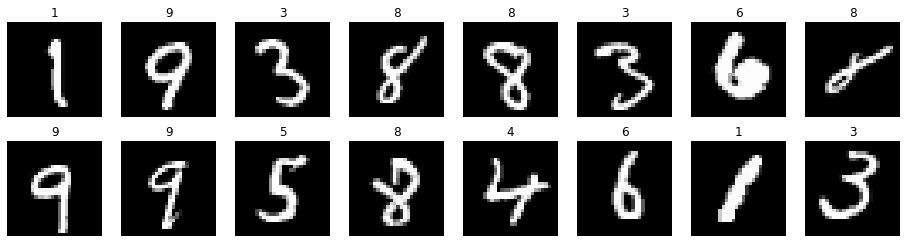

In [ ]:
PlotBatch(train_dataloader)

## MODEL

In [ ]:
class MNIST(nn.Module):
  def __init__(self):
    super(MNIST, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(784, 64),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(64, 10)
    )
  
  def forward(self, x):
    out = self.model(x)
    return out

In [ ]:
model = MNIST()
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [ ]:
def train(epochs, batch_size = 16, print_every = 50):
  total_loss = 0 # average of losses over all of the batches
  accuracy = []
  tic = time()

  for i, batch in enumerate(train_dataloader,1):  # i represents number of batches starting from 1
    model_input = batch[:,1:]/255.0
    target = batch[:,0]

    model_output = model(model_input)
    loss = criterion(model_output, target)
    total_loss+= loss.item()  # as it is just a tensor of 0 dimension, so converting it to a scalar by .item() method
    # backpropoagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  # updating the gradients

    res = model_output.argmax(dim=1)
    accuracy.append((res==target).sum().item()/batch_size) # accuracy over a batch

    if i%print_every==0:   # should print something after every 'print_every' no. of batches are processed
      print('Epoch [{}] ({}/{}), train_loss = {:.4f}, accuracy = {:.2f}, time = {:.2f} sec'.format(epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time() - tic ))
  return total_loss/len(train_dataloader)


In [ ]:
def test(epochs, batch_size = 16, print_every = 50):
  total_loss = 0
  accuracy = []
  tic = time()
  
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader, 0):
      model_input = batch[:,1:]/255.0
      target = batch[:,0]

      model_output = model(model_input)
      loss = criterion(model_output, target)
      total_loss+= loss.item()

      result = model_output.argmax(dim=1)
      accuracy.append((result==target).sum().item()/target.shape[0]) 
  print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-tic
    ))
  return total_loss/len(test_dataloader) # Returning Average Testing Loss



In [ ]:
lr = 1e-4
model = MNIST()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss = []
test_loss = []
for epoch in range(1, 51):
  train_loss.append(train(epoch, batch_size=16, print_every=500 ))
  test_loss.append(test(epoch, batch_size = 16, print_every=500 ))
  print("\n")

Epoch [1] (500/2100), train_loss = 1.1335, accuracy = 0.57, time = 0.89 sec
Epoch [1] (1000/2100), train_loss = 0.7162, accuracy = 0.67, time = 1.82 sec
Epoch [1] (1500/2100), train_loss = 0.3144, accuracy = 0.72, time = 2.73 sec
Epoch [1] (2000/2100), train_loss = 0.7716, accuracy = 0.75, time = 3.64 sec
Epoch: [1], Test Loss: 0.5684, Accuracy: 0.85, Time: 0.34 sec


Epoch [2] (500/2100), train_loss = 0.5832, accuracy = 0.86, time = 0.92 sec
Epoch [2] (1000/2100), train_loss = 0.4079, accuracy = 0.86, time = 1.84 sec
Epoch [2] (1500/2100), train_loss = 0.2813, accuracy = 0.86, time = 2.83 sec
Epoch [2] (2000/2100), train_loss = 0.7187, accuracy = 0.86, time = 3.78 sec
Epoch: [2], Test Loss: 0.4439, Accuracy: 0.88, Time: 0.37 sec


Epoch [3] (500/2100), train_loss = 0.2937, accuracy = 0.88, time = 0.97 sec
Epoch [3] (1000/2100), train_loss = 0.4118, accuracy = 0.88, time = 1.91 sec
Epoch [3] (1500/2100), train_loss = 0.2300, accuracy = 0.88, time = 2.91 sec
Epoch [3] (2000/2100), train

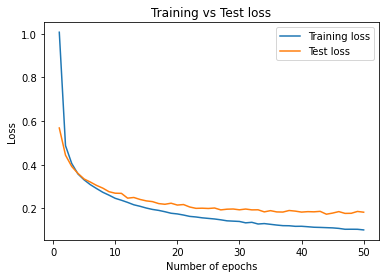

In [ ]:
# plotting the test vs train loss curve
plt.plot(range(1, len(train_loss)+1), train_loss, label = "Training loss")
plt.plot(range(1, len(test_loss)+1), test_loss, label = "Test loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title("Training vs Test loss")
plt.legend()
plt.show()

In [ ]:
# checking our results visually on the pred_set
def Check_model(start):  # from which example we have to plot
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    img_num = start + i
    input = torch.tensor(pred_dataset[img_num,:])/255.0
    op = model(input)
    pred = op.argmax().item()
    fig.add_subplot(2,8,i+1)
    plt.imshow(input.reshape(28,28), cmap = 'gray')
    plt.title(pred)
    plt.axis('off')


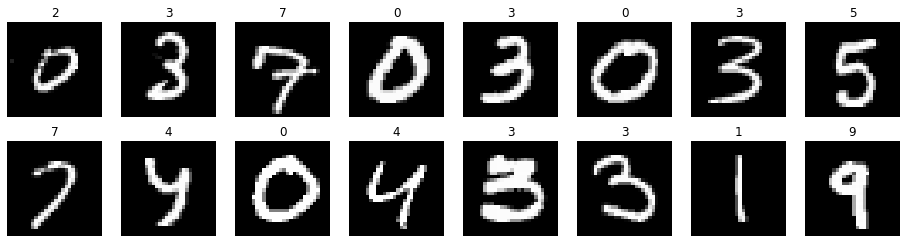

In [ ]:
Check_model(3)  # model is performing quite well on the test set(acc=0.95) and on the pred set(by seeing the visualizations)

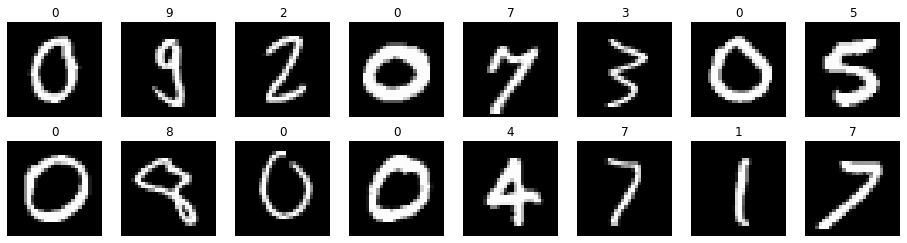

In [ ]:
Check_model(100)

In [ ]:
# predictions on the pred datset
def pred():
  image_id = np.arange(1, pred_dataset.shape[0]+1).reshape(pred_dataset.shape[0],1)
  res = np.zeros((pred_dataset.shape[0],1))
  for i in range(pred_dataset.shape[0]):
    input = torch.tensor(pred_dataset[i,:])/255.0
    op = model(input)
    ans = op.argmax().item()
    res[i] = ans
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))
  pred_df.columns = ['ImageId', 'Label']
  return pred_df

In [ ]:
pred_df = pred()
pred_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
# model is performing well, so let's make a submission
submission = pred_df.to_csv('Submission.csv')